# NBA Bet Predictor

This is the source code for the NBA bet predictor.

### Imports

In [5]:
# basics
import numpy as np 
import pandas as pd

# pre-processing
import sqlite3
import os

# visuals 
from IPython.display import display
import matplotlib.pyplot as plt

# ann
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import re

# regression
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, QuantileRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score

### Pre-processing

In [6]:
conn = sqlite3.connect("./nba.sqlite")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

def get_player_stats(mode="overall", season="00222"):
    selector_string = ""
    if mode == "season":
        selector = "AND SUBSTRING(game_id, 1, 5) = \"{season}\"".format(season=season)
    elif mode == "overall":
        selector = "AND player_name IN (SELECT player_name FROM active_players)"
    tables = pd.read_sql("""
    WITH active_players AS (
        SELECT
            case
                when player1_name is not null
                then player1_name
                else case
                    when player2_name is not null
                    then player2_name
                    else case
                        when player3_name is not null
                        then player3_name
                        else null
                    end
                end
            end as player_name
            from play_by_play
            where player_name is not null
            AND SUBSTRING(game_id, 1, 5) = "{season}"
            and eventmsgtype in (1,3,4)
            group by player_name
    ),
    points_lines AS (
        SELECT 
            game_id, 
            homedescription, 
            visitordescription, 
            player1_name as player_name,
            max(eventnum)
        FROM play_by_play
        WHERE (eventmsgtype = 1 OR eventmsgtype = 3)
        {selector}
        AND score IS NOT NULL
        AND SUBSTRING(game_id, 1, 3) = "002"
        group by game_id, player1_id
    ),
    rebounds_lines AS (
        SELECT 
            game_id, 
            homedescription, 
            visitordescription, 
            player1_name as player_name,
            max(eventnum)
        FROM play_by_play
        WHERE eventmsgtype = 4
        {selector}
        AND SUBSTRING(game_id, 1, 3) = "002"
        group by game_id, player1_id
    ),
    assists_lines AS (
        SELECT 
            game_id, 
            homedescription, 
            visitordescription,
            player2_name as player_name,
            max(eventnum)
        FROM play_by_play
        WHERE eventmsgtype = 1
        {selector}
        AND SUBSTRING(game_id, 1, 3) = "002"
        AND score IS NOT NULL
        group by game_id, player2_id
    )
    SELECT
        p.game_id,
        p.homedescription as points_homedescription,
        p.visitordescription as points_visitordescription,
        r.homedescription as rebounds_homedescription,
        r.visitordescription as rebounds_visitordescription,
        a.homedescription as assists_homedescription,
        a.visitordescription as assists_visitordescription,
        p.player_name as points_getter,
        r.player_name as rebounds_getter,
        a.player_name as assists_getter
    FROM points_lines p
    LEFT JOIN rebounds_lines r ON p.game_id = r.game_id AND p.player_name = r.player_name
    LEFT JOIN assists_lines a ON p.game_id = a.game_id AND p.player_name = a.player_name
    """.format(selector=selector, season=season), conn)
    
    new_table = tables.copy()
    
    import re
    
    def extract_points(description):
        if not description:
            return None
        match = re.search(r'(\d+)\sPTS', description)
        return int(match.group(1)) if match else None
    
    def extract_rebounds(description):
        if not description:
            return None
        match = re.search(r'Off:(\d+)\sDef:(\d+)', description)
        return int(match.group(1)) + int(match.group(2)) if match else None
    
    def extract_assists(description):
        if not description:
            return None
        match = re.search(r'(\d+)\sAST', description)
        return int(match.group(1)) if match else None
    
    # Apply the functions to the respective columns to extract just the numbers
    new_table['points_home'] = new_table['points_homedescription'].apply(extract_points)
    new_table['points_visitor'] = new_table['points_visitordescription'].apply(extract_points)
    
    new_table['rebounds_home'] = new_table['rebounds_homedescription'].apply(extract_rebounds)
    new_table['rebounds_visitor'] = new_table['rebounds_visitordescription'].apply(extract_rebounds)
    
    new_table['assists_home'] = new_table['assists_homedescription'].apply(extract_assists)
    new_table['assists_visitor'] = new_table['assists_visitordescription'].apply(extract_assists)
    
    new_table['points_home'] = new_table['points_home'].astype('Int64')
    new_table['points_visitor'] = new_table['points_visitor'].astype('Int64')
    
    new_table['rebounds_home'] = new_table['rebounds_home'].astype('Int64')
    new_table['rebounds_visitor'] = new_table['rebounds_visitor'].astype('Int64')
    
    new_table['assists_home'] = new_table['assists_home'].astype('Int64')
    new_table['assists_visitor'] = new_table['assists_visitor'].astype('Int64')
    
    new_table['points_home'] = new_table['points_home'].fillna(0)
    new_table['points_visitor'] = new_table['points_visitor'].fillna(0)
    
    new_table['rebounds_home'] = new_table['rebounds_home'].fillna(0)
    new_table['rebounds_visitor'] = new_table['rebounds_visitor'].fillna(0)
    
    new_table['assists_home'] = new_table['assists_home'].fillna(0)
    new_table['assists_visitor'] = new_table['assists_visitor'].fillna(0)
    
    new_table.drop(columns=['points_homedescription', 'points_visitordescription', 'rebounds_homedescription', 'rebounds_visitordescription', 'assists_homedescription', 'assists_visitordescription'], inplace=True)
    
    season_totals = new_table.groupby('points_getter').agg(
        total_points_home=('points_home', 'sum'),
        total_points_visitor=('points_visitor', 'sum'),
        total_rebounds_home=('rebounds_home', 'sum'),
        total_rebounds_visitor=('rebounds_visitor', 'sum'),
        total_assists_home=('assists_home', 'sum'),
        total_assists_visitor=('assists_visitor', 'sum')
    ).reset_index()
    
    season_totals['total_points'] = season_totals['total_points_home'] + season_totals['total_points_visitor']
    season_totals['total_rebounds'] = season_totals['total_rebounds_home'] + season_totals['total_rebounds_visitor']
    season_totals['total_assists'] = season_totals['total_assists_home'] + season_totals['total_assists_visitor']
    
    season_totals.drop(columns=['total_points_home', 'total_points_visitor', 
                                'total_rebounds_home', 'total_rebounds_visitor', 
                                'total_assists_home', 'total_assists_visitor'], inplace=True)
    
    games_played = new_table.groupby('points_getter')['game_id'].nunique().reset_index()
    games_played.rename(columns={'game_id': 'games_played'}, inplace=True)
    
    season_totals = season_totals.merge(games_played, on='points_getter', how='left')
    
    season_totals['avg_points'] = (season_totals['total_points'] / season_totals['games_played']).round(1)
    season_totals['avg_rebounds'] = (season_totals['total_rebounds'] / season_totals['games_played']).round(1)
    season_totals['avg_assists'] = (season_totals['total_assists'] / season_totals['games_played']).round(1)
    
    season_totals.drop(columns=['total_points', 'total_rebounds', 'total_assists'], inplace=True)
    
    season_totals = season_totals[season_totals['games_played'] >= 10]
    season_totals = season_totals.rename(columns={'points_getter': 'player_name'})
    
    return season_totals

overall_stats = get_player_stats()
season_stats = get_player_stats(mode="season")
overall_stats = overall_stats.rename(columns={
    'games_played': 'overall_games_played',
    'avg_points': 'overall_avg_points',
    'avg_rebounds': 'overall_avg_rebounds',
    'avg_assists': 'overall_avg_assists',
})
stats = pd.merge(season_stats, overall_stats, on='player_name', how='left')

def get_player_stats_against_team(season="00222"):
    tables = pd.read_sql("""
    WITH active_players AS (
        SELECT
            case
                when player1_name is not null
                then player1_name
                else case
                    when player2_name is not null
                    then player2_name
                    else case
                        when player3_name is not null
                        then player3_name
                        else null
                    end
                end
            end as player_name
            from play_by_play
            where player_name is not null
            AND SUBSTRING(game_id, 1, 5) = "{season}"
            and eventmsgtype in (1,3,4)
            group by player_name
    ),
    points_lines AS (
        SELECT 
            game_id, 
            homedescription, 
            visitordescription, 
            player1_name as player_name,
            max(eventnum)
        FROM play_by_play
        WHERE (eventmsgtype = 1 OR eventmsgtype = 3)
        AND player_name IN (SELECT player_name FROM active_players)
        AND score IS NOT NULL
        AND SUBSTRING(game_id, 1, 3) = "002"
        group by game_id, player1_id
    ),
    rebounds_lines AS (
        SELECT 
            game_id, 
            homedescription, 
            visitordescription, 
            player1_name as player_name,
            max(eventnum)
        FROM play_by_play
        WHERE eventmsgtype = 4
        AND player_name IN (SELECT player_name FROM active_players)
        AND SUBSTRING(game_id, 1, 3) = "002"
        group by game_id, player1_id
    ),
    assists_lines AS (
        SELECT 
            game_id, 
            homedescription, 
            visitordescription,
            player2_name as player_name,
            max(eventnum)
        FROM play_by_play
        WHERE eventmsgtype = 1
        AND player_name IN (SELECT player_name FROM active_players)
        AND score IS NOT NULL
        AND SUBSTRING(game_id, 1, 3) = "002"
        group by game_id, player2_id
    )
    SELECT
        p.game_id,
        p.homedescription as points_homedescription,
        p.visitordescription as points_visitordescription,
        r.homedescription as rebounds_homedescription,
        r.visitordescription as rebounds_visitordescription,
        a.homedescription as assists_homedescription,
        a.visitordescription as assists_visitordescription,
        p.player_name as points_getter,
        r.player_name as rebounds_getter,
        a.player_name as assists_getter,
        case
            when p.homedescription is not null or r.homedescription is not null or a.homedescription is not null
            then g.team_name_away
            else g.team_name_home
        end as enemy_team
    FROM points_lines p
    LEFT JOIN rebounds_lines r ON p.game_id = r.game_id AND p.player_name = r.player_name
    LEFT JOIN assists_lines a ON p.game_id = a.game_id AND p.player_name = a.player_name
    LEFT JOIN game g ON p.game_id = g.game_id
    """.format(season=season), conn)
    
    new_table = tables.copy()
    
    import re
    
    def extract_points(description):
        if not description:
            return None
        match = re.search(r'(\d+)\sPTS', description)
        return int(match.group(1)) if match else None
    
    def extract_rebounds(description):
        if not description:
            return None
        match = re.search(r'Off:(\d+)\sDef:(\d+)', description)
        return int(match.group(1)) + int(match.group(2)) if match else None
    
    def extract_assists(description):
        if not description:
            return None
        match = re.search(r'(\d+)\sAST', description)
        return int(match.group(1)) if match else None
    
    # Apply the functions to the respective columns to extract just the numbers
    new_table['points_home'] = new_table['points_homedescription'].apply(extract_points)
    new_table['points_visitor'] = new_table['points_visitordescription'].apply(extract_points)
    
    new_table['rebounds_home'] = new_table['rebounds_homedescription'].apply(extract_rebounds)
    new_table['rebounds_visitor'] = new_table['rebounds_visitordescription'].apply(extract_rebounds)
    
    new_table['assists_home'] = new_table['assists_homedescription'].apply(extract_assists)
    new_table['assists_visitor'] = new_table['assists_visitordescription'].apply(extract_assists)
    
    new_table['points_home'] = new_table['points_home'].astype('Int64')
    new_table['points_visitor'] = new_table['points_visitor'].astype('Int64')
    
    new_table['rebounds_home'] = new_table['rebounds_home'].astype('Int64')
    new_table['rebounds_visitor'] = new_table['rebounds_visitor'].astype('Int64')
    
    new_table['assists_home'] = new_table['assists_home'].astype('Int64')
    new_table['assists_visitor'] = new_table['assists_visitor'].astype('Int64')
    
    new_table['points_home'] = new_table['points_home'].fillna(0)
    new_table['points_visitor'] = new_table['points_visitor'].fillna(0)
    
    new_table['rebounds_home'] = new_table['rebounds_home'].fillna(0)
    new_table['rebounds_visitor'] = new_table['rebounds_visitor'].fillna(0)
    
    new_table['assists_home'] = new_table['assists_home'].fillna(0)
    new_table['assists_visitor'] = new_table['assists_visitor'].fillna(0)
    
    new_table.drop(columns=['points_homedescription', 'points_visitordescription', 'rebounds_homedescription', 'rebounds_visitordescription', 'assists_homedescription', 'assists_visitordescription'], inplace=True)
    
    season_totals = new_table.groupby(['points_getter', 'enemy_team']).agg(
        total_points_home=('points_home', 'sum'),
        total_points_visitor=('points_visitor', 'sum'),
        total_rebounds_home=('rebounds_home', 'sum'),
        total_rebounds_visitor=('rebounds_visitor', 'sum'),
        total_assists_home=('assists_home', 'sum'),
        total_assists_visitor=('assists_visitor', 'sum')
    ).reset_index()
    
    season_totals['total_points'] = season_totals['total_points_home'] + season_totals['total_points_visitor']
    season_totals['total_rebounds'] = season_totals['total_rebounds_home'] + season_totals['total_rebounds_visitor']
    season_totals['total_assists'] = season_totals['total_assists_home'] + season_totals['total_assists_visitor']
    
    season_totals.drop(columns=['total_points_home', 'total_points_visitor', 
                                'total_rebounds_home', 'total_rebounds_visitor', 
                                'total_assists_home', 'total_assists_visitor'], inplace=True)
    
    games_played = new_table.groupby(['points_getter', 'enemy_team'])['game_id'].nunique().reset_index()
    games_played.rename(columns={'game_id': 'games_played'}, inplace=True)
    
    season_totals = pd.merge(season_totals, games_played, on=["points_getter", "enemy_team"], how="left")
    
    season_totals['avg_points'] = (season_totals['total_points'] / season_totals['games_played']).round(1)
    season_totals['avg_rebounds'] = (season_totals['total_rebounds'] / season_totals['games_played']).round(1)
    season_totals['avg_assists'] = (season_totals['total_assists'] / season_totals['games_played']).round(1)
    
    season_totals.drop(columns=['total_points', 'total_rebounds', 'total_assists'], inplace=True)
    
    # season_totals = season_totals[season_totals['games_played'] >= 10]
    season_totals = season_totals.rename(columns={
        'points_getter': 'player_name',
        'avg_points': 'avg_points_against_enemy',
        'avg_rebounds': 'avg_rebounds_against_enemy',
        'avg_assists': 'avg_assists_against_enemy',
    })
    
    return new_table, season_totals

games_played, season_totals = get_player_stats_against_team()

season_totals = season_totals.rename(columns={"games_played": "games_played_against_enemy"})
stats_final = pd.merge(season_totals, stats, on="player_name", how="left")
stats_final = stats_final[stats_final['games_played'].notna()].reset_index().drop(columns=["index"])

games = games_played.drop(columns=['rebounds_getter', 'assists_getter'])
games = games.rename(columns={'points_getter': 'player_name'})
games['game_points'] = games.apply(lambda x: x['points_home'] if x['points_home'] > x['points_visitor'] else x['points_visitor'], axis=1)
games['game_rebounds'] = games.apply(lambda x: x['rebounds_home'] if x['rebounds_home'] > x['rebounds_visitor'] else x['rebounds_visitor'], axis=1)
games['game_assists'] = games.apply(lambda x: x['assists_home'] if x['assists_home'] > x['assists_visitor'] else x['assists_visitor'], axis=1)
games['is_home'] = games.apply(lambda x: 0 if x['assists_home'] == 0 and x['rebounds_home'] == 0 and x['points_home'] == 0 else 1, axis=1)
games = games.drop(columns=['points_home', 'points_visitor', 'rebounds_home', 'rebounds_visitor', 'assists_home', 'assists_visitor'])
games = games.loc[games["game_id"].str[:5] == "00222"].reset_index().drop(columns='index')

data = pd.merge(games, stats_final, on=['player_name', 'enemy_team'], how='left')
data = data[data['games_played_against_enemy'].notna()].reset_index().drop(columns=["index"])
data = data[data['games_played'].notna()].reset_index().drop(columns=["index"])
data = data[data['overall_games_played'].notna()].reset_index().drop(columns=["index"])
data_og = data

### Regression

##### Data Collection

In [7]:
def over_under_accuracy(x, y, y_pred, stat):
    test = None
    pred = None
    if stat == "points":
        test = (y < x['avg_points']).astype(int)
        pred = (y_pred < x['avg_points']).astype(int)
    elif stat == "rebounds":
        test = (y < x['avg_rebounds']).astype(int)
        pred = (y_pred < x['avg_rebounds']).astype(int)
    elif stat == "assists":
        test = (y < x['avg_assists']).astype(int)
        pred = (y_pred < x['avg_assists']).astype(int)
    return 1 - np.mean(np.abs(test - pred))

data = data_og.drop(columns=["player_name", "game_id"])
data_encoded = pd.get_dummies(data, columns=["enemy_team"])

#output will be game_points
df_points = data[[ 'enemy_team', 'is_home', 'games_played_against_enemy', 'games_played', 'overall_games_played', 'game_points', 'avg_points_against_enemy', 'avg_points', 'overall_avg_points']]
#output will be game_rebounds
df_rebounds = data[[ 'enemy_team', 'is_home', 'games_played_against_enemy', 'games_played', 'overall_games_played', 'game_rebounds', 'avg_rebounds_against_enemy', 'avg_rebounds', 'overall_avg_rebounds']]
#output will be game_assists
df_assists = data[[ 'enemy_team', 'is_home', 'games_played_against_enemy', 'games_played', 'overall_games_played', 'game_assists', 'avg_assists_against_enemy', 'avg_assists', 'overall_avg_assists']]

#representing categorical value (name, team) with dummies
df_points_encoded = pd.get_dummies(df_points, columns=[ 'enemy_team'])
df_rebounds_encoded = pd.get_dummies(df_rebounds, columns=[ 'enemy_team'])
df_assists_encoded = pd.get_dummies(df_assists, columns=['enemy_team'])

##### Points

Stat-specific features

test1a - points using linear reg (only relevant features)
R-squared: 0.61
Mean Squared Error: 30.12
Over-under Accuracy: 0.62
Cross-Validated MSE: 30.073595160635193


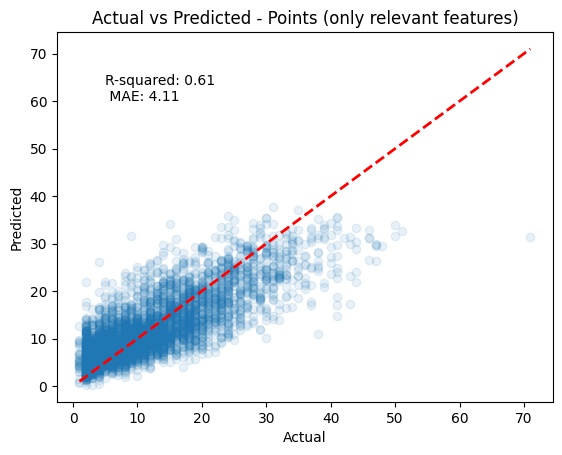

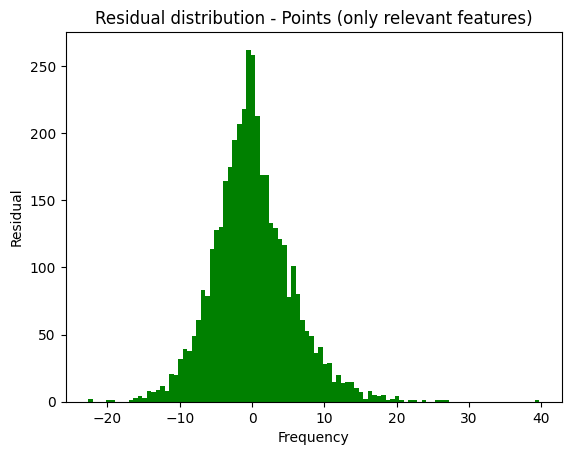

In [8]:
#test1 using linear reg
#X = df_points[['game_id', 'player_name', 'enemy_team', 'is_home', 'games_played_against_enemy', 'games_played', 'overall_games_played', 'avg_points_against_enemy', 'avg_points', 'overall_avg_points']]
#y = df_points['game_points']

X = df_points_encoded.drop(columns=['game_points'])
y = df_points_encoded['game_points']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = np.mean(np.abs(y_test - y_pred))

print("test1a - points using linear reg (only relevant features)")
print(f"R-squared: {r2:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Over-under Accuracy: {over_under_accuracy(X_test, y_test, y_pred, "points"):.2f}")

scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-Validated MSE: {(-scores).mean()}")

#graph visual actual vs predicted
plt.scatter(y_test, y_pred, alpha=0.1)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
plt.title('Actual vs Predicted - Points (only relevant features)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.text(5, 60, s=f'R-squared: {r2:.2f}\n MAE: {mae:.2f}', fontsize=10)
plt.show()

#residual
residual = y_test - y_pred
plt.hist(residual, bins=100, color='g')
plt.title('Residual distribution - Points (only relevant features)')
plt.xlabel('Frequency')
plt.ylabel('Residual')
plt.show()

All features

test1b - points using linear reg (all features)
R-squared: 0.65
Mean Squared Error: 27.34
Over-under Accuracy: 0.67
Cross-Validated MSE: 27.468306301503628


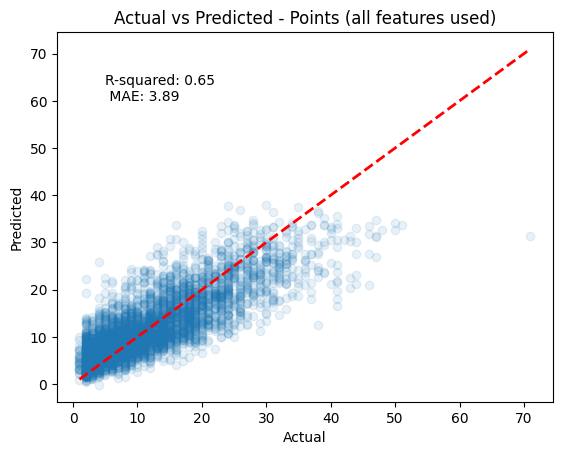

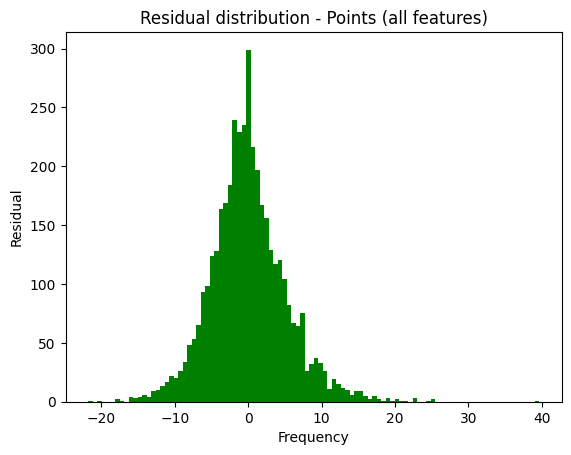

In [9]:
#representing categorical value (name, team) with dummies
df_data_encoded = pd.get_dummies(data, columns=[ 'enemy_team'])

X = df_data_encoded.drop(columns=['game_points'])
y = df_data_encoded['game_points']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = np.mean(np.abs(y_test - y_pred))

print("test1b - points using linear reg (all features)")
print(f"R-squared: {r2:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Over-under Accuracy: {over_under_accuracy(X_test, y_test, y_pred, "points"):.2f}")

scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-Validated MSE: {(-scores).mean()}")

#graph visual actual vs predicted
plt.scatter(y_test, y_pred, alpha=0.1)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
plt.title('Actual vs Predicted - Points (all features used)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.text(5, 60, s=f'R-squared: {r2:.2f}\n MAE: {mae:.2f}', fontsize=10)
plt.show()

#residual
residual = y_test - y_pred
plt.hist(residual, bins=100, color='g')
plt.title('Residual distribution - Points (all features)')
plt.xlabel('Frequency')
plt.ylabel('Residual')
plt.show()

All features (2-poly)

test 1c - points using linear reg poly deg 2 (all features)
R-squared: 0.64
Mean Squared Error: 28.16
Mean Absolute Error: 3.95
Cross-Validated MSE: 27.468306301503628


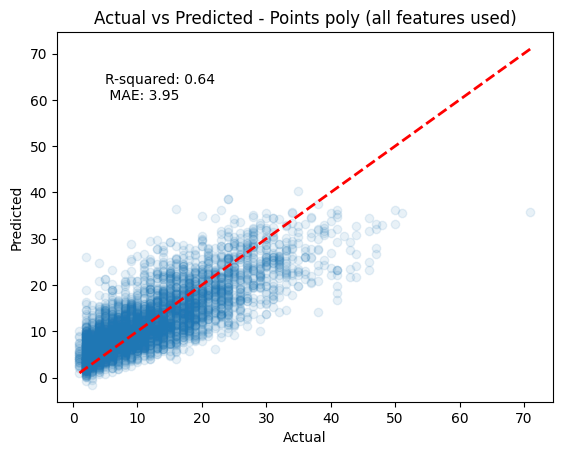

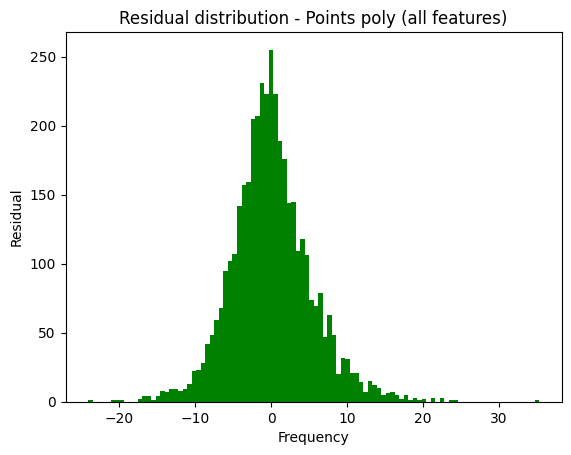

In [10]:
X = data_encoded.drop(columns=['game_points'])
y = data_encoded['game_points']

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=1)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = np.mean(np.abs(y_test - y_pred))


print("test 1c - points using linear reg poly deg 2 (all features)")
print(f"R-squared: {r2:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")

scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-Validated MSE: {(-scores).mean()}")

#graph visual actual vs predicted
plt.scatter(y_test, y_pred, alpha=0.1)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
plt.title('Actual vs Predicted - Points poly (all features used)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.text(5, 60, s=f'R-squared: {r2:.2f}\n MAE: {mae:.2f}', fontsize=10)
plt.show()

#residual
residual = y_test - y_pred
plt.hist(residual, bins=100, color='g')
plt.title('Residual distribution - Points poly (all features)')
plt.xlabel('Frequency')
plt.ylabel('Residual')
plt.show()

##### Rebounds

Stat-specific features

test2a - rebounds using linear reg (only relevant features)
R-squared: 0.56
Mean Squared Error: 5.22
Over-under Accuracy: 0.62
Cross-Validated MSE: 5.286392075145079


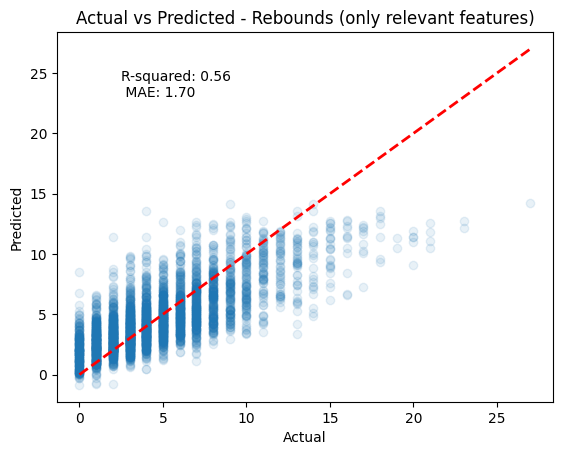

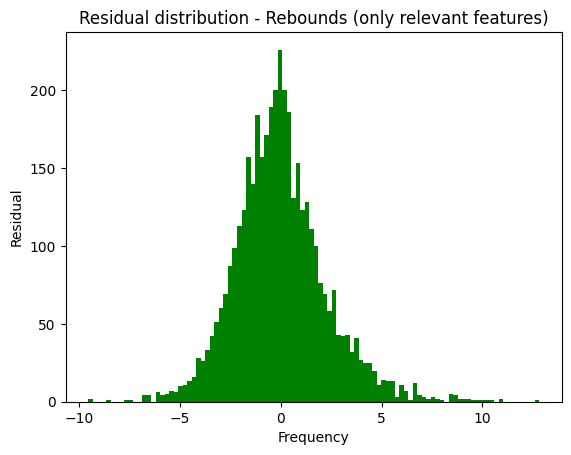

In [11]:
X = df_rebounds_encoded.drop(columns=['game_rebounds'])
y = df_rebounds_encoded['game_rebounds']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = np.mean(np.abs(y_test - y_pred))

print("test2a - rebounds using linear reg (only relevant features)")
print(f"R-squared: {r2:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Over-under Accuracy: {over_under_accuracy(X_test, y_test, y_pred, "rebounds"):.2f}")

scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-Validated MSE: {(-scores).mean()}")

#graph visual actual vs predicted
plt.scatter(y_test, y_pred, alpha=0.1)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
plt.title('Actual vs Predicted - Rebounds (only relevant features)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.text(2.5, 23, s=f'R-squared: {r2:.2f}\n MAE: {mae:.2f}', fontsize=10)
plt.show()

#residual
residual = y_test - y_pred
plt.hist(residual, bins=100, color='g')
plt.title('Residual distribution - Rebounds (only relevant features)')
plt.xlabel('Frequency')
plt.ylabel('Residual')
plt.show()

All features

test2b - rebounds using linear reg (all features)
R-squared: 0.61
Mean Squared Error: 4.62
Over-under Accuracy: 0.66
Cross-Validated MSE: 4.779405042912376


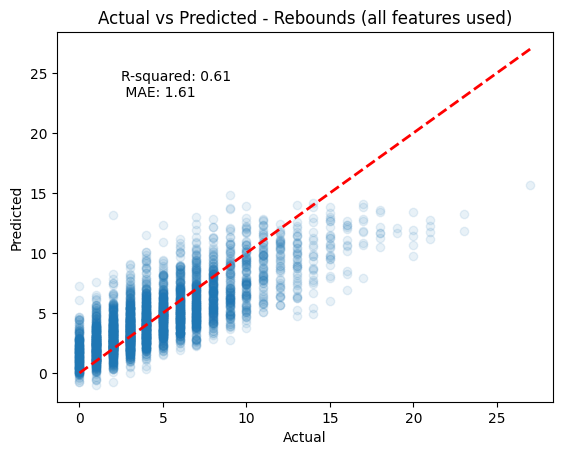

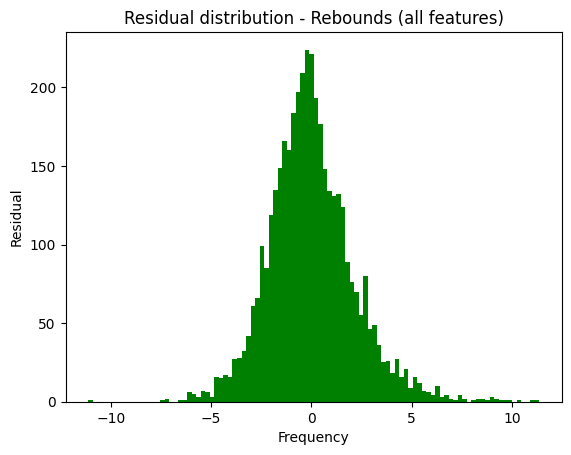

In [12]:
#representing categorical value (name, team) with dummies
df_data_encoded = pd.get_dummies(data, columns=['enemy_team'])

X = df_data_encoded.drop(columns=['game_rebounds'])
y = df_data_encoded['game_rebounds']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = np.mean(np.abs(y_test - y_pred))

print("test2b - rebounds using linear reg (all features)")
print(f"R-squared: {r2:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Over-under Accuracy: {over_under_accuracy(X_test, y_test, y_pred, "rebounds"):.2f}")

scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-Validated MSE: {(-scores).mean()}")

#graph visual actual vs predicted
plt.scatter(y_test, y_pred, alpha=0.1)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
plt.title('Actual vs Predicted - Rebounds (all features used)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.text(2.5, 23, s=f'R-squared: {r2:.2f}\n MAE: {mae:.2f}', fontsize=10)
plt.show()

#residual
residual = y_test - y_pred
plt.hist(residual, bins=100, color='g')
plt.title('Residual distribution - Rebounds (all features)')
plt.xlabel('Frequency')
plt.ylabel('Residual')
plt.show()

All features (2-poly)

test 2c - rebounds using linear reg poly deg 2 (all features)
R-squared: 0.61
Mean Squared Error: 4.59
Mean Absolute Error: 1.62
Cross-Validated MSE: 4.779405042912376


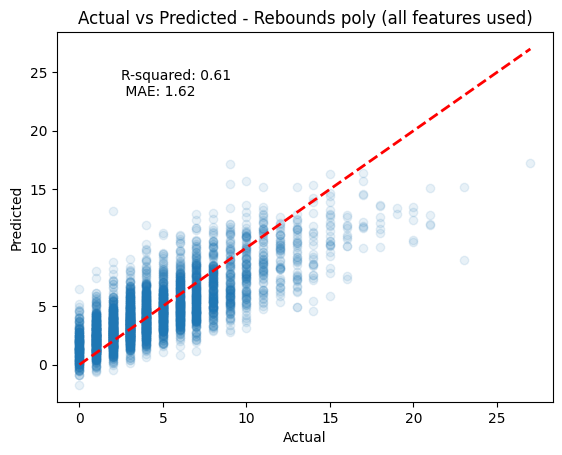

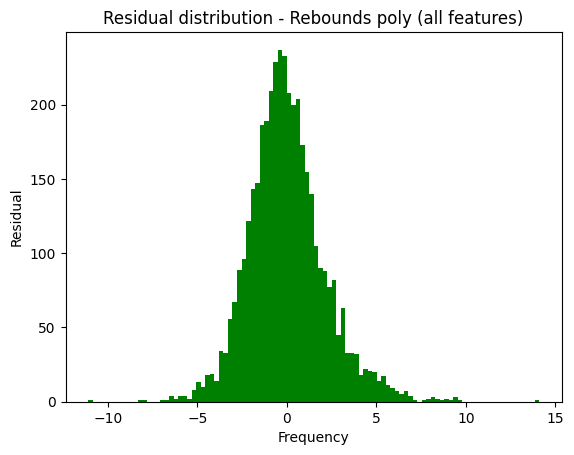

In [13]:
X = data_encoded.drop(columns=['game_rebounds'])
y = data_encoded['game_rebounds']

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=1)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = np.mean(np.abs(y_test - y_pred))

print("test 2c - rebounds using linear reg poly deg 2 (all features)")
print(f"R-squared: {r2:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")

scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-Validated MSE: {(-scores).mean()}")

#graph visual actual vs predicted
plt.scatter(y_test, y_pred, alpha=0.1)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
plt.title('Actual vs Predicted - Rebounds poly (all features used)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.text(2.5, 23, s=f'R-squared: {r2:.2f}\n MAE: {mae:.2f}', fontsize=10)
plt.show()

#residual
residual = y_test - y_pred
plt.hist(residual, bins=100, color='g')
plt.title('Residual distribution - Rebounds poly (all features)')
plt.xlabel('Frequency')
plt.ylabel('Residual')
plt.show()

##### Assists

Stat-specific features

test3a - assists using linear reg (only relevant features)
R-squared: 0.60
Mean Squared Error: 2.85
Cross-Validated MSE: 2.7298655090374866


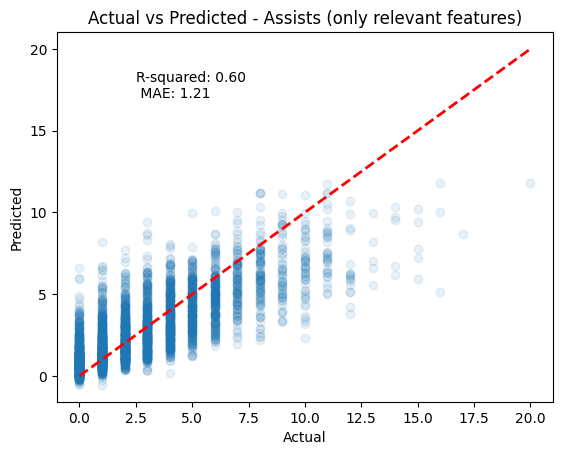

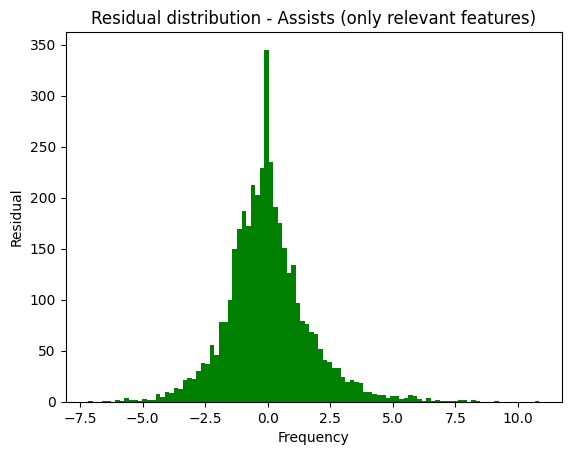

In [14]:
X = df_assists_encoded.drop(columns=['game_assists'])
y = df_assists_encoded['game_assists']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = np.mean(np.abs(y_test - y_pred))

print("test3a - assists using linear reg (only relevant features)")
print(f"R-squared: {r2:.2f}")
print(f"Mean Squared Error: {mse:.2f}")

scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-Validated MSE: {(-scores).mean()}")

#graph visual actual vs predicted
plt.scatter(y_test, y_pred, alpha=0.1)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
plt.title('Actual vs Predicted - Assists (only relevant features)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.text(2.5, 17, s=f'R-squared: {r2:.2f}\n MAE: {mae:.2f}', fontsize=10)
plt.show()

#residual
residual = y_test - y_pred
plt.hist(residual, bins=100, color='g')
plt.title('Residual distribution - Assists (only relevant features)')
plt.xlabel('Frequency')
plt.ylabel('Residual')
plt.show()

All features

test3b - assists using linear reg (all) features)
R-squared: 0.63
Mean Squared Error: 2.67
Cross-Validated MSE: 2.5861490385735437


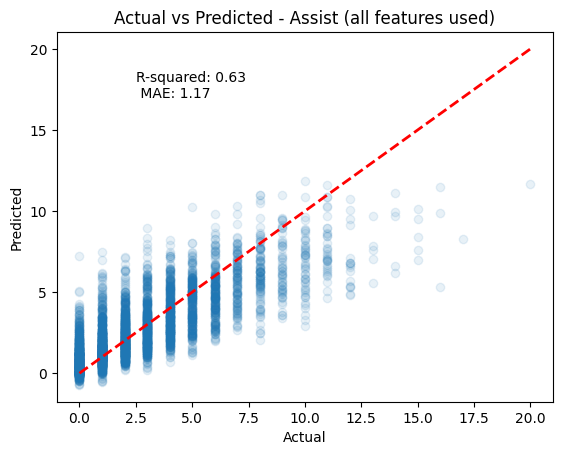

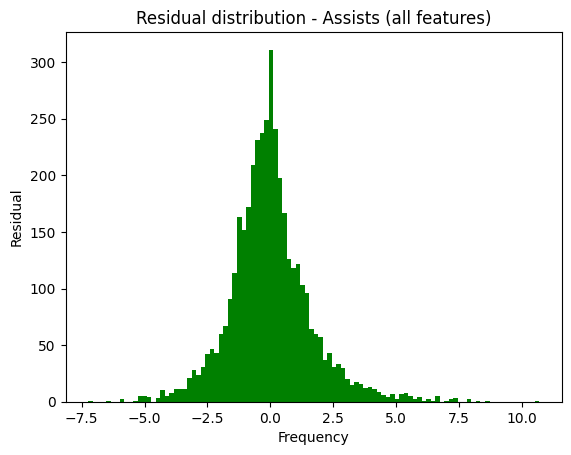

In [15]:
#representing categorical value (name, team) with dummies
df_data_encoded = pd.get_dummies(data, columns=[ 'enemy_team'])

X = df_data_encoded.drop(columns=['game_assists'])
y = df_data_encoded['game_assists']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = np.mean(np.abs(y_test - y_pred))

print("test3b - assists using linear reg (all) features)")
print(f"R-squared: {r2:.2f}")
print(f"Mean Squared Error: {mse:.2f}")

scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-Validated MSE: {(-scores).mean()}")

#graph visual actual vs predicted
plt.scatter(y_test, y_pred, alpha=0.1)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
plt.title('Actual vs Predicted - Assist (all features used)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.text(2.5, 17, s=f'R-squared: {r2:.2f}\n MAE: {mae:.2f}', fontsize=10)
plt.show()

#residual
residual = y_test - y_pred
plt.hist(residual, bins=100, color='g')
plt.title('Residual distribution - Assists (all features)')
plt.xlabel('Frequency')
plt.ylabel('Residual')
plt.show()

All features (2-poly)

test 3c - assists using linear reg poly deg 2 (all features)
R-squared: 0.62
Mean Squared Error: 2.71
Mean Absolute Error: 1.18
Cross-Validated MSE: 2.5861490385735437


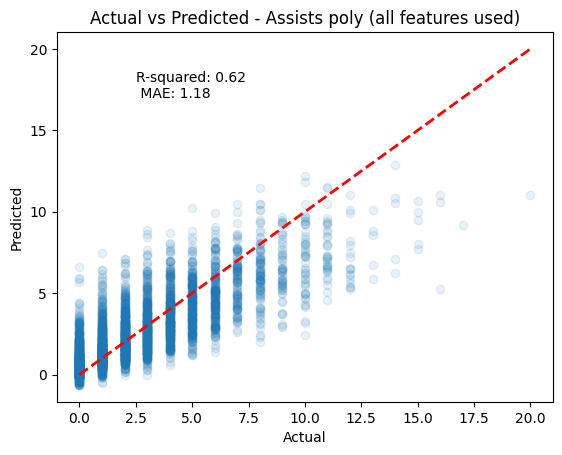

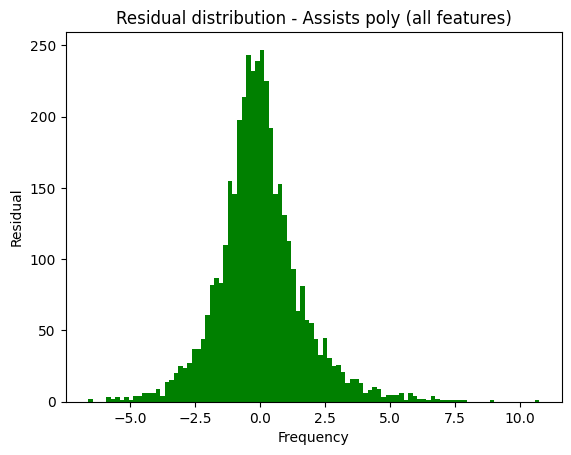

In [16]:
X = data_encoded.drop(columns=['game_assists'])
y = data_encoded['game_assists']

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=1)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = np.mean(np.abs(y_test - y_pred))

print("test 3c - assists using linear reg poly deg 2 (all features)")
print(f"R-squared: {r2:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")

scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-Validated MSE: {(-scores).mean()}")

#graph visual actual vs predicted
plt.scatter(y_test, y_pred, alpha=0.1)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
plt.title('Actual vs Predicted - Assists poly (all features used)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.text(2.5, 17, s=f'R-squared: {r2:.2f}\n MAE: {mae:.2f}', fontsize=10)
plt.show()

#residual
residual = y_test - y_pred
plt.hist(residual, bins=100, color='g')
plt.title('Residual distribution - Assists poly (all features)')
plt.xlabel('Frequency')
plt.ylabel('Residual')
plt.show()

### ANN

##### Points

,is_home,games_played_against_enemy,avg_points_against_enemy,avg_rebounds_against_enemy,avg_assists_against_enemy,games_played,avg_points,avg_rebounds,avg_assists,overall_games_played,overall_avg_points,overall_avg_rebounds,overall_avg_assists,enemy_team_Atlanta Hawks,enemy_team_Boston Celtics,enemy_team_Brooklyn Nets,enemy_team_Charlotte Hornets,enemy_team_Chicago Bulls,enemy_team_Cleveland Cavaliers,enemy_team_Dallas Mavericks,enemy_team_Denver Nuggets,enemy_team_Detroit Pistons,enemy_team_Golden State Warriors,enemy_team_Houston Rockets,enemy_team_Indiana Pacers,enemy_team_LA Clippers,enemy_team_Los Angeles Lakers,enemy_team_Memphis Grizzlies,enemy_team_Miami Heat,enemy_team_Milwaukee Bucks,enemy_team_Minnesota Timberwolves,enemy_team_New Orleans Pelicans,enemy_team_New York Knicks,enemy_team_Oklahoma City Thunder,enemy_team_Orlando Magic,enemy_team_Philadelphia 76ers,enemy_team_Phoenix Suns,enemy_team_Portland Trail Blazers,enemy_team_Sacramento Kings,enemy_team_San Antonio Spurs,enemy_team_Toronto Raptors,enemy_team_Utah Jazz,enemy_team_Washington Wizards
0,0.0,16.0,11.1,5.2,1.2,39.0,7.2,3.2,0.6,446.0,13.2,5.3,1.4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,23.0,14.9,4.3,1.8,62.0,26.1,6.9,3.5,429.0,18.2,5.3,2.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,14.0,14.6,4.2,4.1,62.0,14.5,4.2,3.8,366.0,15.2,4.2,4.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,10.0,6.0,1.7,0.6,61.0,9.5,2.5,1.0,285.0,7.9,2.4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,6.0,6.8,4.3,0.7,39.0,5.6,1.8,0.8,217.0,8.5,3.4,1.2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20361,1.0,3.0,7.0,3.7,0.0,35.0,5.5,2.8,0.8,35.0,5.5,2.8,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20362,0.0,32.0,26.5,4.7,6.6,46.0,29.4,6.0,6.2,721.0,24.9,4.8,6.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
20363,0.0,30.0,21.5,3.5,2.3,61.0,21.6,4.1,2.3,572.0,20.2,3.5,2.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
20364,0.0,27.0,8.9,8.7,6.6,63.0,8.4,7.2,6.8,609.0,9.5,7.4,6.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Fold 1
Epoch 2/100, Loss: 0.6578, Val Accuracy: 0.6088
Epoch 10/100, Loss: 0.6369, Val Accuracy: 0.6118
Epoch 20/100, Loss: 0.6309, Val Accuracy: 0.6198
Epoch 30/100, Loss: 0.6290, Val Accuracy: 0.6255
Epoch 40/100, Loss: 0.6284, Val Accuracy: 0.6244
Epoch 50/100, Loss: 0.6255, Val Accuracy: 0.6188
Epoch 60/100, Loss: 0.6227, Val Accuracy: 0.6255
Epoch 70/100, Loss: 0.6230, Val Accuracy: 0.5999
Epoch 80/100, Loss: 0.6212, Val Accuracy: 0.6314
Epoch 90/100, Loss: 0.6225, Val Accuracy: 0.6225
Epoch 100/100, Loss: 0.6174, Val Accuracy: 0.6202
Fold 2
Epoch 2/100, Loss: 0.6703, Val Accuracy: 0.6041
Epoch 10/100, Loss: 0.6339, Val Accuracy: 0.6214
Epoch 20/100, Loss: 0.6294, Val Accuracy: 0.6240
Epoch 30/100, Loss: 0.6257, Val Accuracy: 0.6219
Epoch 40/100, Loss: 0.6234, Val Accuracy: 0.6276
Epoch 50/100, Loss: 0.6212, Val Accuracy: 0.6186
Epoch 60/100, Loss: 0.6187, Val Accuracy: 0.6147
Epoch 70/100, Loss: 0.6173, Val Accuracy: 0.6084
Epoch 80/100, Loss: 0.6171, Val Accuracy: 0.6229
Epoch 9

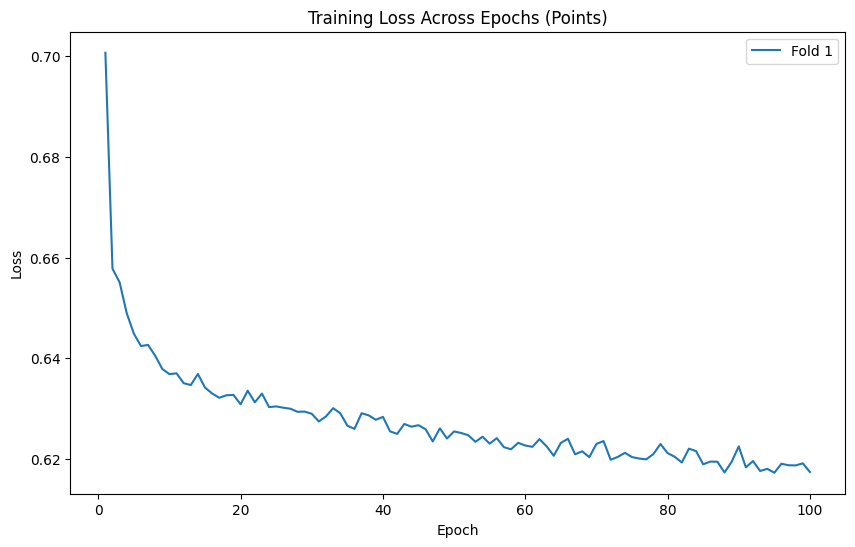

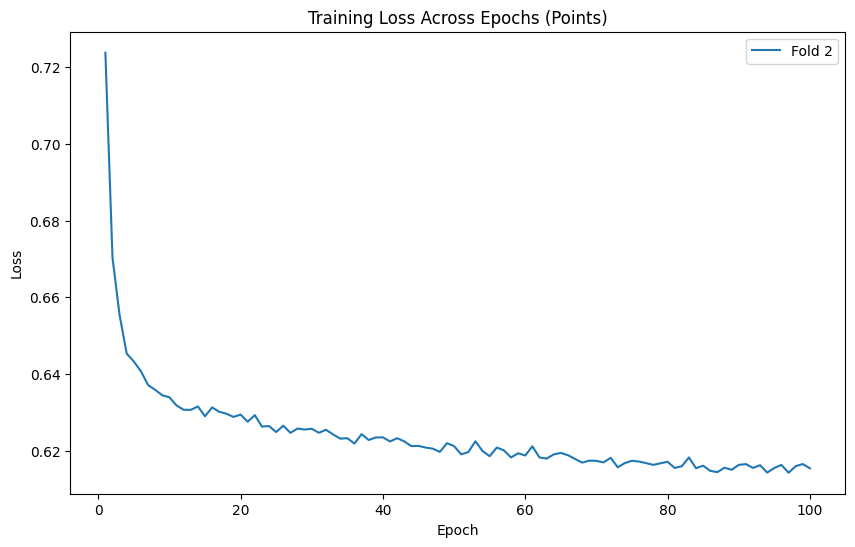

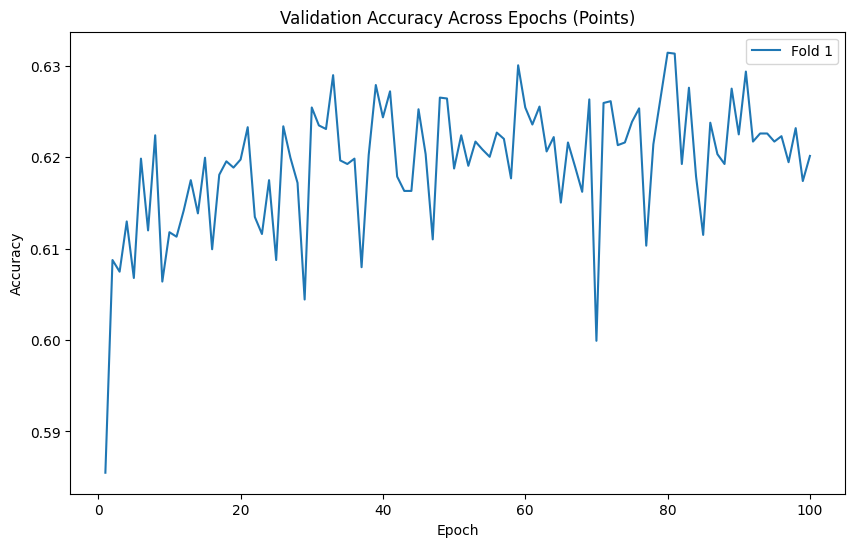

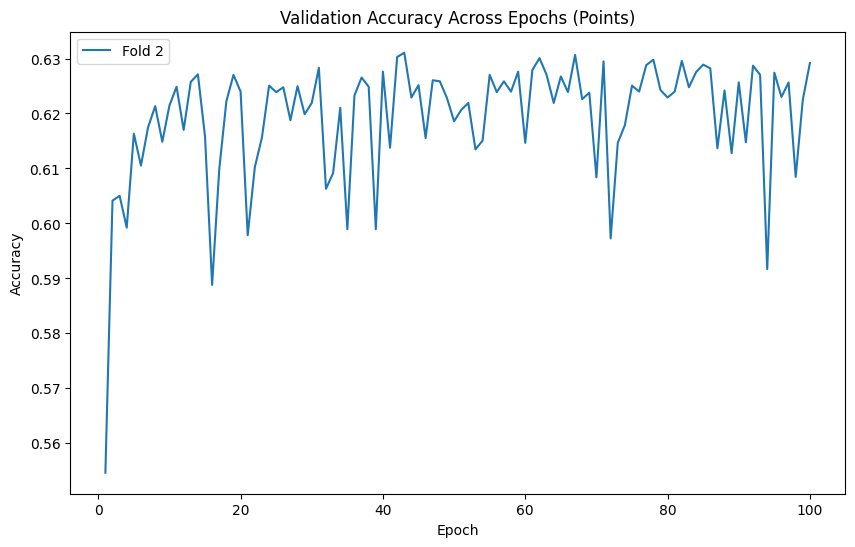

In [17]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Extract from table and clean up features
data = data_og
data = data.drop(columns=["player_name", "game_id"])
data = pd.get_dummies(data, columns=['enemy_team'])
data['is_under_points'] = (data['game_points'] < data['avg_points']).astype(int)
data['is_under_rebounds'] = (data['game_rebounds'] < data['avg_rebounds']).astype(int)
data['is_under_assists'] = (data['game_assists'] < data['avg_assists']).astype(int)

# ANN with 2-Fold Cross-Validation
# Features and target
# features = season_totals[['avg_points', 'avg_rebounds', 'avg_assists']].values
features = data.drop(columns=['game_points', 'game_rebounds', 'game_assists', 'is_under_points', 'is_under_rebounds', 'is_under_assists'])
for col in features.columns:
    features[col] = features[col].astype(float)
display(features)
features = features.values
target = data['is_under_points'].values

# Convert to PyTorch tensors
X_tensor = torch.tensor(features, dtype=torch.float32)
y_tensor = torch.tensor(target, dtype=torch.long)

# Define ANN model
class OverUnderANN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(OverUnderANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)
        # Note: We will remove the softmax layer here, as nn.CrossEntropyLoss expects raw logits
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        # No softmax activation
        return x

# 2-Fold Cross-Validation
kf = KFold(n_splits=2, shuffle=True, random_state=42)
fold = 1
epochs = 100
train_losses = []
val_accuracies = []

for train_idx, val_idx in kf.split(X_tensor):
    print(f"Fold {fold}")
    # Split data
    X_train, X_val = X_tensor[train_idx], X_tensor[val_idx]
    y_train, y_val = y_tensor[train_idx], y_tensor[val_idx]

    # Create DataLoader
    train_dataset = TensorDataset(X_train, y_train)
    # Adjust batch size if training data is small
    batch_size = min(16, len(train_dataset))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Initialize model
    input_size = X_train.shape[1]
    model = OverUnderANN(input_size, hidden_size1=12, hidden_size2=12, output_size=2)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train
    fold_train_loss = []
    fold_val_accuracy = []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        fold_train_loss.append(total_loss / len(train_loader))

        # Validate
        model.eval()
        with torch.no_grad():
            outputs = model(X_val)
            _, predicted = torch.max(outputs.data, 1)
            accuracy = accuracy_score(y_val.numpy(), predicted.numpy())
            fold_val_accuracy.append(accuracy)

        if (epoch+1) % 10 == 0 or epoch == 1:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {fold_train_loss[-1]:.4f}, Val Accuracy: {accuracy:.4f}")

    train_losses.append(fold_train_loss)
    val_accuracies.append(fold_val_accuracy)
    fold += 1

# Plot Training Loss
for i, losses in enumerate(train_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), losses, label=f'Fold {i+1}')
    plt.title('Training Loss Across Epochs (Points)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plot Validation Accuracy
for i, accuracies in enumerate(val_accuracies):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), accuracies, label=f'Fold {i+1}')
    plt.title('Validation Accuracy Across Epochs (Points)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

##### Rebounds

Fold 1
Epoch 2/100, Loss: 0.6874, Val Accuracy: 0.5595
Epoch 10/100, Loss: 0.6409, Val Accuracy: 0.6036
Epoch 20/100, Loss: 0.6382, Val Accuracy: 0.6202
Epoch 30/100, Loss: 0.6336, Val Accuracy: 0.6205
Epoch 40/100, Loss: 0.6312, Val Accuracy: 0.6283
Epoch 50/100, Loss: 0.6283, Val Accuracy: 0.6116
Epoch 60/100, Loss: 0.6276, Val Accuracy: 0.6163
Epoch 70/100, Loss: 0.6260, Val Accuracy: 0.6147
Epoch 80/100, Loss: 0.6224, Val Accuracy: 0.6275
Epoch 90/100, Loss: 0.6239, Val Accuracy: 0.6234
Epoch 100/100, Loss: 0.6233, Val Accuracy: 0.6194
Fold 2
Epoch 2/100, Loss: 0.6848, Val Accuracy: 0.5800
Epoch 10/100, Loss: 0.6357, Val Accuracy: 0.6188
Epoch 20/100, Loss: 0.6316, Val Accuracy: 0.6205
Epoch 30/100, Loss: 0.6272, Val Accuracy: 0.6173
Epoch 40/100, Loss: 0.6224, Val Accuracy: 0.6071
Epoch 50/100, Loss: 0.6221, Val Accuracy: 0.6218
Epoch 60/100, Loss: 0.6197, Val Accuracy: 0.6141
Epoch 70/100, Loss: 0.6192, Val Accuracy: 0.6216
Epoch 80/100, Loss: 0.6180, Val Accuracy: 0.6218
Epoch 9

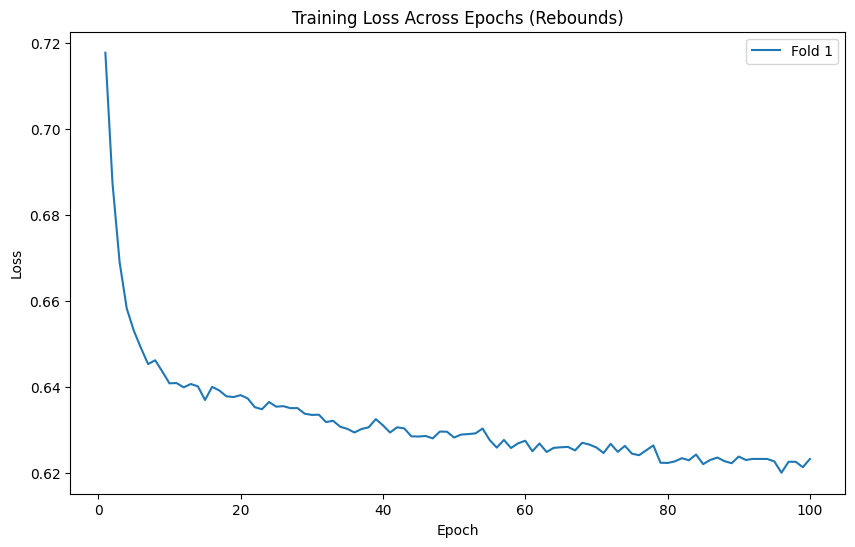

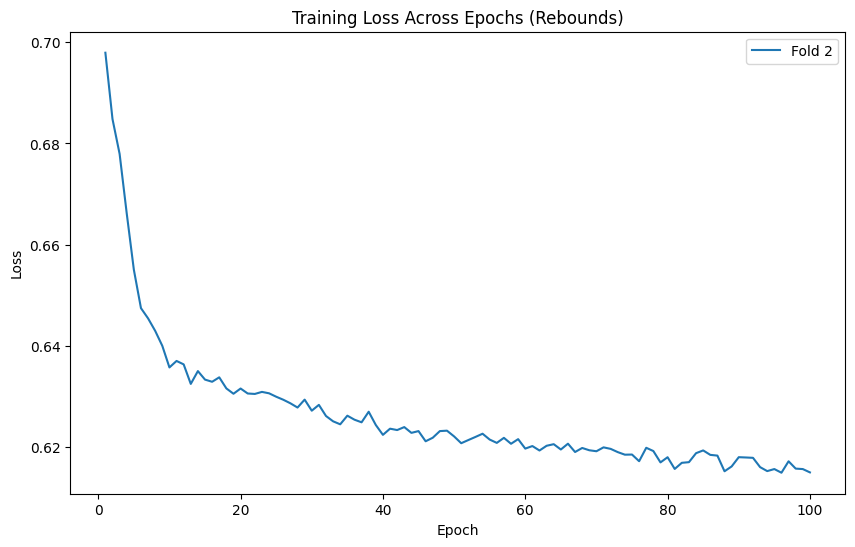

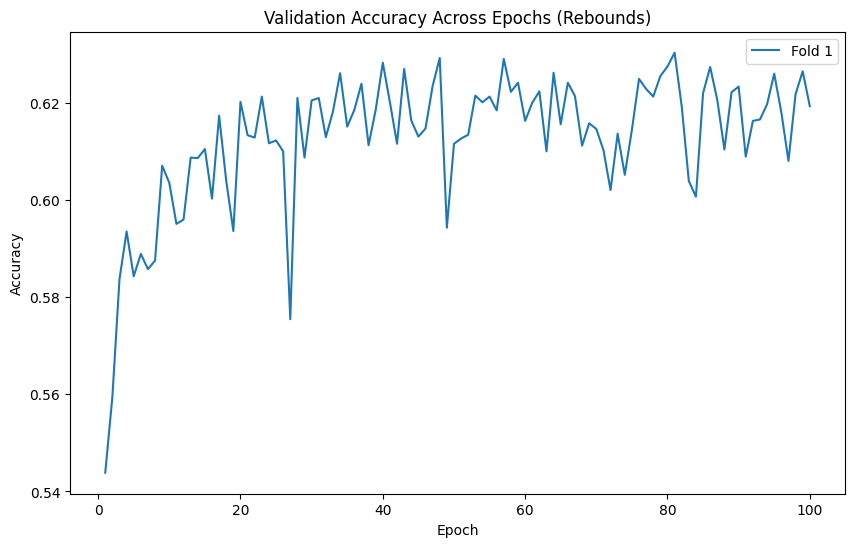

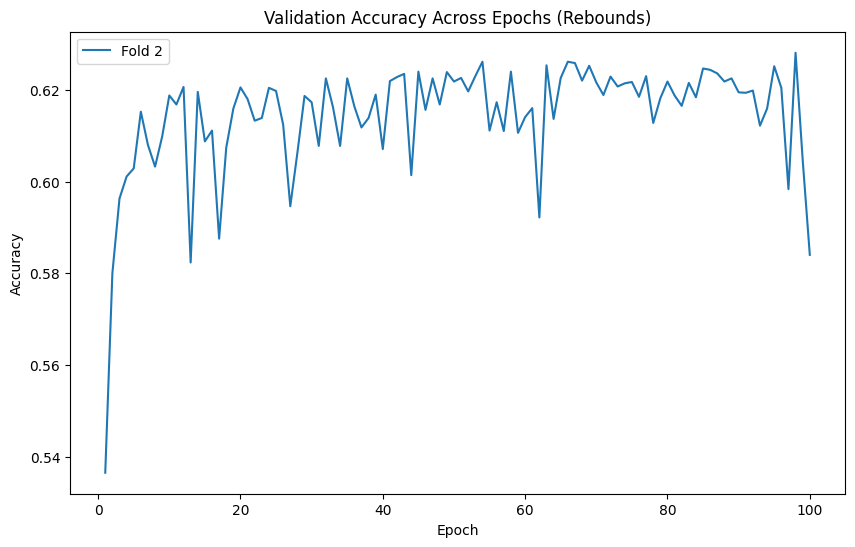

In [18]:
target_rebounds = data['is_under_rebounds'].values

X_tensor = torch.tensor(features, dtype=torch.float32)
y_tensor = torch.tensor(target_rebounds, dtype=torch.long)

# 2-Fold Cross-Validation
kf = KFold(n_splits=2, shuffle=True, random_state=42)
fold = 1
epochs = 100
train_losses = []
val_accuracies = []

for train_idx, val_idx in kf.split(X_tensor):
    print(f"Fold {fold}")
    # Split data
    X_train, X_val = X_tensor[train_idx], X_tensor[val_idx]
    y_train, y_val = y_tensor[train_idx], y_tensor[val_idx]

    # Create DataLoader
    train_dataset = TensorDataset(X_train, y_train)
    # Adjust batch size if training data is small
    batch_size = min(16, len(train_dataset))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Initialize model
    input_size = X_train.shape[1]
    model = OverUnderANN(input_size, hidden_size1=12, hidden_size2=12, output_size=2)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train
    fold_train_loss = []
    fold_val_accuracy = []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        fold_train_loss.append(total_loss / len(train_loader))

        # Validate
        model.eval()
        with torch.no_grad():
            outputs = model(X_val)
            _, predicted = torch.max(outputs.data, 1)
            accuracy = accuracy_score(y_val.numpy(), predicted.numpy())
            fold_val_accuracy.append(accuracy)

        if (epoch+1) % 10 == 0 or epoch == 1:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {fold_train_loss[-1]:.4f}, Val Accuracy: {accuracy:.4f}")

    train_losses.append(fold_train_loss)
    val_accuracies.append(fold_val_accuracy)
    fold += 1

# Plot Training Loss
for i, losses in enumerate(train_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), losses, label=f'Fold {i+1}')
    plt.title('Training Loss Across Epochs (Rebounds)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plot Validation Accuracy
for i, accuracies in enumerate(val_accuracies):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), accuracies, label=f'Fold {i+1}')
    plt.title('Validation Accuracy Across Epochs (Rebounds)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

##### Assists

Fold 1
Epoch 2/100, Loss: 0.6907, Val Accuracy: 0.5560
Epoch 10/100, Loss: 0.6416, Val Accuracy: 0.6038
Epoch 20/100, Loss: 0.6341, Val Accuracy: 0.6138
Epoch 30/100, Loss: 0.6274, Val Accuracy: 0.5997
Epoch 40/100, Loss: 0.6247, Val Accuracy: 0.6148
Epoch 50/100, Loss: 0.6238, Val Accuracy: 0.6051
Epoch 60/100, Loss: 0.6217, Val Accuracy: 0.6138
Epoch 70/100, Loss: 0.6204, Val Accuracy: 0.6259
Epoch 80/100, Loss: 0.6169, Val Accuracy: 0.6234
Epoch 90/100, Loss: 0.6161, Val Accuracy: 0.6181
Epoch 100/100, Loss: 0.6150, Val Accuracy: 0.6157
Fold 2
Epoch 2/100, Loss: 0.6889, Val Accuracy: 0.5535
Epoch 10/100, Loss: 0.6446, Val Accuracy: 0.6113
Epoch 20/100, Loss: 0.6344, Val Accuracy: 0.6220
Epoch 30/100, Loss: 0.6298, Val Accuracy: 0.6202
Epoch 40/100, Loss: 0.6292, Val Accuracy: 0.5939
Epoch 50/100, Loss: 0.6235, Val Accuracy: 0.6160
Epoch 60/100, Loss: 0.6221, Val Accuracy: 0.6262
Epoch 70/100, Loss: 0.6221, Val Accuracy: 0.6257
Epoch 80/100, Loss: 0.6206, Val Accuracy: 0.6262
Epoch 9

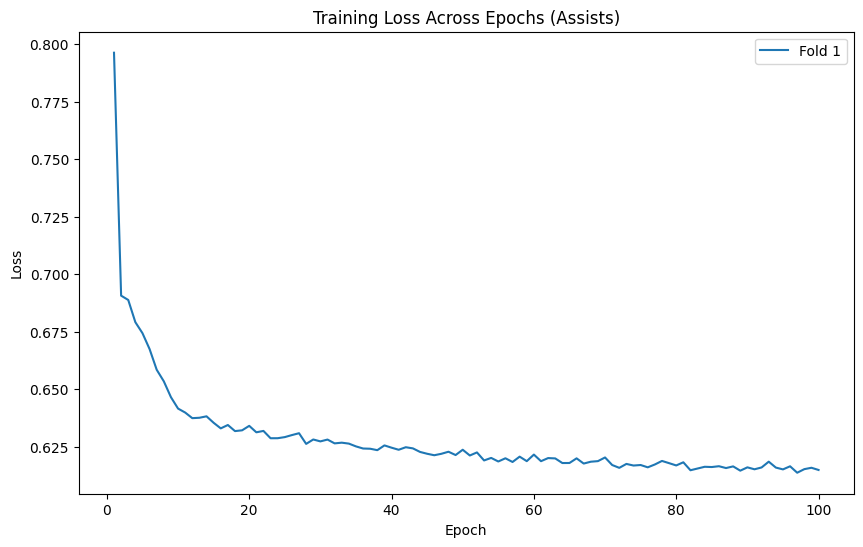

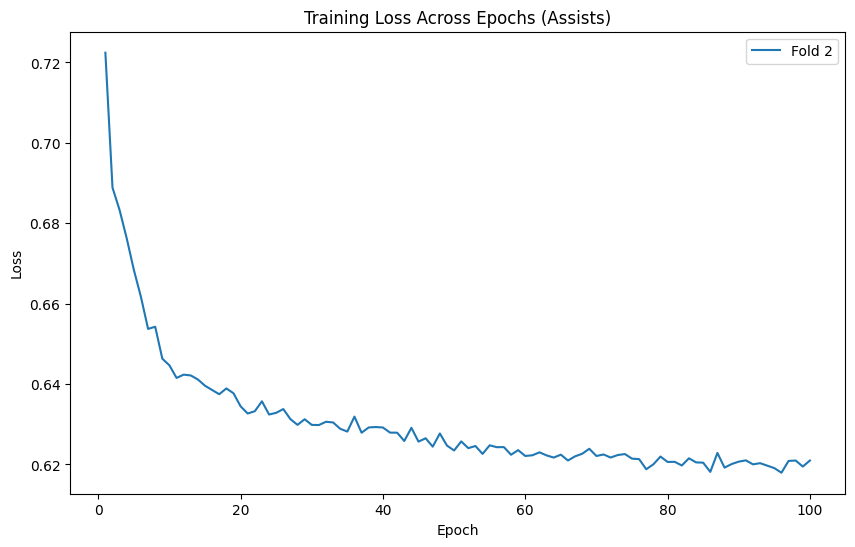

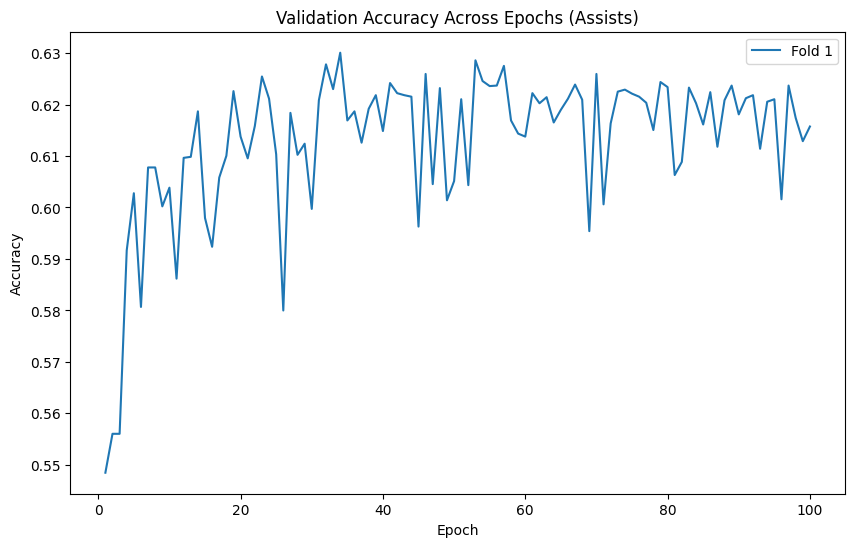

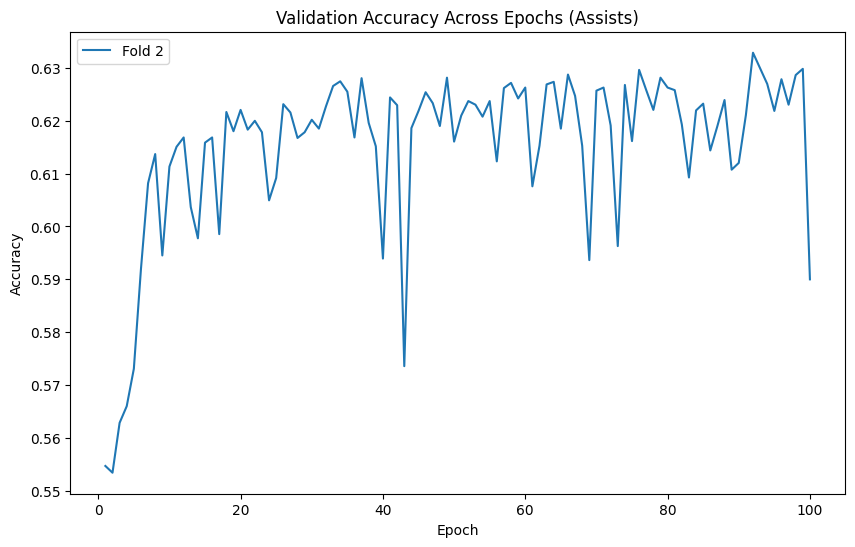

In [19]:
target_assists = data['is_under_assists'].values

X_tensor = torch.tensor(features, dtype=torch.float32)
y_tensor = torch.tensor(target_assists, dtype=torch.long)

# 2-Fold Cross-Validation
kf = KFold(n_splits=2, shuffle=True, random_state=42)
fold = 1
epochs = 100
train_losses = []
val_accuracies = []

for train_idx, val_idx in kf.split(X_tensor):
    print(f"Fold {fold}")
    # Split data
    X_train, X_val = X_tensor[train_idx], X_tensor[val_idx]
    y_train, y_val = y_tensor[train_idx], y_tensor[val_idx]

    # Create DataLoader
    train_dataset = TensorDataset(X_train, y_train)
    # Adjust batch size if training data is small
    batch_size = min(16, len(train_dataset))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Initialize model
    input_size = X_train.shape[1]
    model = OverUnderANN(input_size, hidden_size1=12, hidden_size2=12, output_size=2)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train
    fold_train_loss = []
    fold_val_accuracy = []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        fold_train_loss.append(total_loss / len(train_loader))

        # Validate
        model.eval()
        with torch.no_grad():
            outputs = model(X_val)
            _, predicted = torch.max(outputs.data, 1)
            accuracy = accuracy_score(y_val.numpy(), predicted.numpy())
            fold_val_accuracy.append(accuracy)

        if (epoch+1) % 10 == 0 or epoch == 1:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {fold_train_loss[-1]:.4f}, Val Accuracy: {accuracy:.4f}")

    train_losses.append(fold_train_loss)
    val_accuracies.append(fold_val_accuracy)
    fold += 1

# Plot Training Loss
for i, losses in enumerate(train_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), losses, label=f'Fold {i+1}')
    plt.title('Training Loss Across Epochs (Assists)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plot Validation Accuracy
for i, accuracies in enumerate(val_accuracies):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), accuracies, label=f'Fold {i+1}')
    plt.title('Validation Accuracy Across Epochs (Assists)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()